# Debiasing the data

In [415]:
from folktables import ACSDataSource, BasicProblem, generate_categories
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import  pearsonr
from sklearn.decomposition import PCA
from numpy.testing import assert_array_almost_equal
import scipy
try:
    import seaborn as sns
    sns.set()
except:
    print("Run without Seaborn")

In [416]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)


def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'RELP',
        'WKHP',
        'PWGTP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', 'RAC1P'],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

In [417]:
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)
features.head()

,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,SEX_Male,RAC1P_Black or African American alone,RAC1P_White alone
0,21.0,20.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,65.0,8.0,33.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,33.0,40.0,53.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,18.0,18.0,106.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,27.0,50.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [418]:
# Drop the "redundant" columns
features = features.drop(["RAC1P_White alone", 
                          "SEX_Male", 
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm' ], axis = 1) 

print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" %i, "(%s)"%f)

Columns with the protected features:
Column ID: 54 (SEX_Female)
Column ID: 55 (RAC1P_Black or African American alone)


In [419]:
features.head()

,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,RAC1P_Black or African American alone
0,21.0,20.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,65.0,8.0,33.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,33.0,40.0,53.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18.0,18.0,106.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,27.0,50.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [420]:
groups.head()

,SEX,RAC1P
0,1,1
1,1,1
2,1,1
3,2,1
4,1,1


In [421]:
# Drop the protected columns
features_no_protected = features.drop(["SEX_Female", 
                          "RAC1P_Black or African American alone"], axis = 1) 

In [422]:
features_no_protected.head()

,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Institutionalized group quarters population,RELP_Noninstitutionalized group quarters population,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner
0,21.0,20.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,65.0,8.0,33.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,33.0,40.0,53.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18.0,18.0,106.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,27.0,50.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Task 2.4

## Point 1

In [423]:
from sklearn.preprocessing import MinMaxScaler
mm_scalar = MinMaxScaler()

features_no_protected["AGEP"] = mm_scalar.fit_transform(np.array(features_no_protected["AGEP"]).reshape(-1,1))
features_no_protected["WKHP"] = mm_scalar.fit_transform(np.array(features_no_protected["WKHP"]).reshape(-1,1))
features_no_protected["PWGTP"] = mm_scalar.fit_transform(np.array(features_no_protected["PWGTP"]).reshape(-1,1))

features_no_protected

,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Institutionalized group quarters population,RELP_Noninstitutionalized group quarters population,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner
0,0.051948,0.193878,0.036299,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.623377,0.071429,0.022776,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.207792,0.397959,0.037011,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.012987,0.173469,0.074733,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.129870,0.500000,0.015658,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129558,0.454545,0.295918,0.072598,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
129559,0.480519,0.346939,0.084698,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
129560,0.415584,0.397959,0.031317,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
129561,0.311688,0.908163,0.133808,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [424]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features_no_protected.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)

N = 20000 ### I am subsampling because it is slow on my machine

X_train = X_train[:N]
y_train = y_train[:N]
group_train = group_train[:N]
X_test = X_test[:N]
y_test = y_test[:N]
group_test = group_test[:N]

In [425]:
# protected columns already dropped in features_no_protected so no need to substract 4 for PCA column count
n_components = len(features_no_protected.columns)
print(n_components)

pca = PCA(n_components=n_components) # create a PCA object 
X = pca.fit_transform(features_no_protected) # do the math

pca_columns = []
for i in range(n_components):
    pca_columns.append(f"PC{i}")

54


In [426]:
pca_no_protected = pd.DataFrame(X, columns = pca_columns)
pca_no_protected

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53
0,0.835716,0.164462,0.826447,-0.498418,0.641018,-0.154729,-0.278277,-0.221102,0.212815,0.111683,...,0.005941,0.006390,0.004260,-0.002787,0.001275,-0.003389,0.000177,0.000485,-2.293173e-03,-0.000024
1,0.602770,-0.075234,1.028618,-0.259808,-0.536647,-0.600946,-0.553391,0.228807,0.707891,-0.044259,...,0.003987,0.002347,0.001246,-0.007904,0.000208,-0.002264,0.000721,0.000395,-1.348270e-03,0.000030
2,0.351152,0.324816,-0.236965,-0.094208,-0.214612,0.140504,-0.084028,-0.046230,-0.075631,0.086340,...,0.000075,0.000049,-0.000447,-0.015725,0.000909,-0.000109,0.000067,0.000331,-8.046520e-03,-0.000898
3,0.754217,0.029308,0.967248,-0.090005,-0.195621,-0.081613,-0.208403,-0.114294,0.839663,0.264689,...,-0.009047,-0.007971,-0.004378,-0.002246,-0.001845,-0.001625,-0.001011,-0.000637,-2.749901e-03,0.000019
4,0.707307,-0.041878,0.855188,0.774213,0.159010,-0.043173,-0.243405,-0.166086,0.136476,0.119745,...,0.006483,0.005881,0.003193,-0.002374,0.001452,-0.004360,0.000696,0.000596,-7.713746e-04,0.000090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129558,0.508138,-0.813019,0.655511,-0.221053,-0.007514,0.626072,-0.439695,0.289691,-0.257663,-0.148919,...,0.003868,0.003496,0.001734,-0.001386,0.000231,-0.002232,0.000505,0.000328,-1.672990e-04,0.000015
129559,0.887461,0.328268,-0.080444,-0.019193,-0.262219,0.096525,-0.306161,-0.097581,-0.042735,0.049834,...,-0.000123,0.000377,-0.000512,-0.012156,-0.001251,-0.000290,0.000526,-0.000709,-3.679507e-03,0.000155
129560,-0.436240,-0.331354,-0.712941,-0.174823,-0.117242,0.050803,0.139363,0.096608,0.009052,0.042534,...,0.004291,0.003447,0.001463,-0.003322,0.000757,-0.000803,0.000049,-0.000093,1.019575e-03,-0.000003
129561,-0.568824,0.073607,0.642765,-0.221493,0.070581,0.584871,-0.010162,0.479837,-0.219336,-0.115881,...,-0.015562,-0.015888,-0.012663,-0.005818,-0.003263,0.002770,-0.002348,-0.002393,-6.771585e-07,0.000175


In [427]:
task_1_merged = pd.concat([pca_no_protected, groups], axis=1)
task_1_merged

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,SEX,RAC1P
0,0.835716,0.164462,0.826447,-0.498418,0.641018,-0.154729,-0.278277,-0.221102,0.212815,0.111683,...,0.004260,-0.002787,0.001275,-0.003389,0.000177,0.000485,-2.293173e-03,-0.000024,1,1
1,0.602770,-0.075234,1.028618,-0.259808,-0.536647,-0.600946,-0.553391,0.228807,0.707891,-0.044259,...,0.001246,-0.007904,0.000208,-0.002264,0.000721,0.000395,-1.348270e-03,0.000030,1,1
2,0.351152,0.324816,-0.236965,-0.094208,-0.214612,0.140504,-0.084028,-0.046230,-0.075631,0.086340,...,-0.000447,-0.015725,0.000909,-0.000109,0.000067,0.000331,-8.046520e-03,-0.000898,1,1
3,0.754217,0.029308,0.967248,-0.090005,-0.195621,-0.081613,-0.208403,-0.114294,0.839663,0.264689,...,-0.004378,-0.002246,-0.001845,-0.001625,-0.001011,-0.000637,-2.749901e-03,0.000019,2,1
4,0.707307,-0.041878,0.855188,0.774213,0.159010,-0.043173,-0.243405,-0.166086,0.136476,0.119745,...,0.003193,-0.002374,0.001452,-0.004360,0.000696,0.000596,-7.713746e-04,0.000090,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129558,0.508138,-0.813019,0.655511,-0.221053,-0.007514,0.626072,-0.439695,0.289691,-0.257663,-0.148919,...,0.001734,-0.001386,0.000231,-0.002232,0.000505,0.000328,-1.672990e-04,0.000015,1,1
129559,0.887461,0.328268,-0.080444,-0.019193,-0.262219,0.096525,-0.306161,-0.097581,-0.042735,0.049834,...,-0.000512,-0.012156,-0.001251,-0.000290,0.000526,-0.000709,-3.679507e-03,0.000155,2,1
129560,-0.436240,-0.331354,-0.712941,-0.174823,-0.117242,0.050803,0.139363,0.096608,0.009052,0.042534,...,0.001463,-0.003322,0.000757,-0.000803,0.000049,-0.000093,1.019575e-03,-0.000003,1,1
129561,-0.568824,0.073607,0.642765,-0.221493,0.070581,0.584871,-0.010162,0.479837,-0.219336,-0.115881,...,-0.012663,-0.005818,-0.003263,0.002770,-0.002348,-0.002393,-6.771585e-07,0.000175,1,1


In [428]:
n_features = X_train.shape[1]
alpha = 0.05 ## significance level
corrected_alpha = alpha / (n_features**2/2) # Bonferroni correction for multiple testings

##############################
######### Your code here
##############################
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = float(round(pearsonr(tmp[r], tmp[c])[1], 4))
    return pvalues

In [429]:
p_values = calculate_pvalues(task_1_merged)
p_values = p_values.astype('float')

In [430]:
def heatmap_filtered_relevant(df, p_values, corrected_alpha, title):
    sns.heatmap(df, annot=False, cmap='rocket', linewidths=0.5, linecolor='black', mask=p_values>corrected_alpha)
    plt.title(title, fontsize=24)
    plt.tick_params(axis='both', which='both', labelsize=12)
    plt.tight_layout()

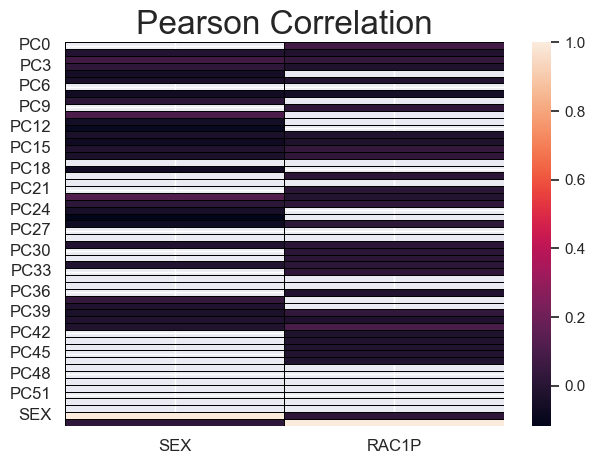

In [431]:
heatmap_filtered_relevant(task_1_merged.corr(method='pearson')[['SEX', 'RAC1P']], p_values[['SEX', 'RAC1P']], corrected_alpha, 'Pearson Correlation')

## Point 2

In [432]:
n_components = len(X_test[0])
print(n_components)

pca = PCA(n_components=n_components) # create a PCA object 
X_test_pca = pca.fit_transform(X_test) # do the math

# project back
X_test_pca_proj_back=pca.inverse_transform(X_test_pca)
rec_errors = X_test - X_test_pca_proj_back

54


In [433]:
rec_errors_pd = pd.DataFrame(rec_errors, columns=features_no_protected.columns)
rec_errors_pd

,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Institutionalized group quarters population,RELP_Noninstitutionalized group quarters population,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner
0,-1.443290e-15,4.996004e-15,-3.927414e-15,-3.375078e-14,5.689893e-15,-8.638923e-16,4.302114e-15,1.554312e-14,9.423018e-15,5.745404e-15,...,-1.485791e-15,-2.683617e-14,-2.543105e-15,-4.309053e-15,3.582204e-16,3.639311e-13,-1.252470e-15,-2.827599e-15,-5.072331e-15,-8.298917e-15
1,-3.885781e-16,-1.110223e-15,-7.216450e-16,-2.209344e-14,3.066991e-15,-1.065814e-14,3.413936e-15,-4.954370e-15,4.179990e-14,2.109424e-15,...,5.464379e-16,5.297845e-15,1.826664e-15,3.243933e-16,-1.401873e-16,-3.241851e-14,-8.170548e-16,1.700029e-16,1.386044e-15,-1.082467e-15
2,5.551115e-17,-5.551115e-17,7.771561e-16,-2.331468e-15,2.553513e-15,-8.847090e-16,2.331468e-15,1.144917e-15,1.110223e-15,-1.387779e-16,...,8.430756e-16,2.352285e-15,-2.272488e-16,-3.452100e-16,-1.772671e-16,-1.387779e-15,1.595946e-16,1.141448e-15,1.153591e-16,5.828671e-16
3,-2.775558e-16,-8.326673e-16,5.551115e-17,-3.552714e-15,2.672862e-14,1.887032e-14,3.093359e-14,9.776902e-15,3.608225e-14,2.303019e-14,...,5.290907e-17,5.016820e-15,-7.459311e-17,-8.309325e-16,-6.570265e-17,1.282308e-14,1.214306e-16,-3.747003e-16,-4.683753e-16,3.191891e-16
4,5.551115e-17,-1.110223e-16,-1.179612e-16,4.440892e-16,-1.901257e-15,4.343748e-15,2.153833e-14,1.183775e-14,1.580680e-14,8.111567e-15,...,4.536302e-16,-8.291978e-16,-7.788908e-16,-3.382711e-16,2.352719e-17,4.440892e-16,-2.064321e-16,2.255141e-16,-6.331741e-17,-7.979728e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-5.551115e-17,-1.665335e-16,-1.942890e-16,1.332268e-15,1.665335e-16,-2.116363e-16,-6.938894e-17,-4.024558e-16,-8.326673e-17,3.469447e-17,...,-3.469447e-18,-7.632783e-17,-2.949030e-17,-9.887924e-17,5.453537e-17,-2.442491e-15,-1.752071e-16,-7.632783e-17,-7.112366e-17,-5.551115e-16
19996,-2.775558e-16,-5.551115e-16,2.151057e-16,-4.440892e-16,3.053113e-16,8.014422e-16,2.636780e-16,-2.289835e-16,1.942890e-16,2.567391e-16,...,-2.255141e-17,-8.673617e-16,2.498002e-16,1.890849e-16,1.695692e-16,1.276756e-15,-5.204170e-18,3.105155e-16,2.159731e-16,3.955170e-16
19997,4.440892e-16,-2.220446e-16,1.387779e-16,1.110223e-15,-2.081668e-16,-5.967449e-16,3.885781e-16,7.632783e-17,3.469447e-16,6.245005e-17,...,1.396452e-16,4.614364e-16,-3.365364e-16,-1.752071e-16,-4.098284e-16,-1.776357e-15,3.989864e-17,-2.706169e-16,4.683753e-17,5.620504e-16
19998,3.330669e-16,5.551115e-17,-4.163336e-17,9.992007e-16,-2.220446e-16,3.226586e-16,-8.187895e-16,-6.245005e-17,3.191891e-16,-1.249001e-16,...,1.040834e-17,3.053113e-16,-1.734723e-18,1.006140e-16,3.252607e-17,5.551115e-16,1.040834e-17,-3.469447e-18,-8.673617e-18,-4.926615e-16


In [434]:
group_test

,SEX,RAC1P
72476,2,1
108056,1,1
128094,1,1
46044,1,1
42380,1,1
...,...,...
78970,2,1
53318,1,1
89865,1,1
103333,1,1


In [435]:
task_2_merged = pd.concat([rec_errors_pd.reset_index(), group_test.reset_index()], axis=1)
task_2_merged = task_2_merged.drop(["index"], axis = 1)
task_2_merged

,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX,RAC1P
0,-1.443290e-15,4.996004e-15,-3.927414e-15,-3.375078e-14,5.689893e-15,-8.638923e-16,4.302114e-15,1.554312e-14,9.423018e-15,5.745404e-15,...,-2.543105e-15,-4.309053e-15,3.582204e-16,3.639311e-13,-1.252470e-15,-2.827599e-15,-5.072331e-15,-8.298917e-15,2,1
1,-3.885781e-16,-1.110223e-15,-7.216450e-16,-2.209344e-14,3.066991e-15,-1.065814e-14,3.413936e-15,-4.954370e-15,4.179990e-14,2.109424e-15,...,1.826664e-15,3.243933e-16,-1.401873e-16,-3.241851e-14,-8.170548e-16,1.700029e-16,1.386044e-15,-1.082467e-15,1,1
2,5.551115e-17,-5.551115e-17,7.771561e-16,-2.331468e-15,2.553513e-15,-8.847090e-16,2.331468e-15,1.144917e-15,1.110223e-15,-1.387779e-16,...,-2.272488e-16,-3.452100e-16,-1.772671e-16,-1.387779e-15,1.595946e-16,1.141448e-15,1.153591e-16,5.828671e-16,1,1
3,-2.775558e-16,-8.326673e-16,5.551115e-17,-3.552714e-15,2.672862e-14,1.887032e-14,3.093359e-14,9.776902e-15,3.608225e-14,2.303019e-14,...,-7.459311e-17,-8.309325e-16,-6.570265e-17,1.282308e-14,1.214306e-16,-3.747003e-16,-4.683753e-16,3.191891e-16,1,1
4,5.551115e-17,-1.110223e-16,-1.179612e-16,4.440892e-16,-1.901257e-15,4.343748e-15,2.153833e-14,1.183775e-14,1.580680e-14,8.111567e-15,...,-7.788908e-16,-3.382711e-16,2.352719e-17,4.440892e-16,-2.064321e-16,2.255141e-16,-6.331741e-17,-7.979728e-16,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-5.551115e-17,-1.665335e-16,-1.942890e-16,1.332268e-15,1.665335e-16,-2.116363e-16,-6.938894e-17,-4.024558e-16,-8.326673e-17,3.469447e-17,...,-2.949030e-17,-9.887924e-17,5.453537e-17,-2.442491e-15,-1.752071e-16,-7.632783e-17,-7.112366e-17,-5.551115e-16,2,1
19996,-2.775558e-16,-5.551115e-16,2.151057e-16,-4.440892e-16,3.053113e-16,8.014422e-16,2.636780e-16,-2.289835e-16,1.942890e-16,2.567391e-16,...,2.498002e-16,1.890849e-16,1.695692e-16,1.276756e-15,-5.204170e-18,3.105155e-16,2.159731e-16,3.955170e-16,1,1
19997,4.440892e-16,-2.220446e-16,1.387779e-16,1.110223e-15,-2.081668e-16,-5.967449e-16,3.885781e-16,7.632783e-17,3.469447e-16,6.245005e-17,...,-3.365364e-16,-1.752071e-16,-4.098284e-16,-1.776357e-15,3.989864e-17,-2.706169e-16,4.683753e-17,5.620504e-16,1,1
19998,3.330669e-16,5.551115e-17,-4.163336e-17,9.992007e-16,-2.220446e-16,3.226586e-16,-8.187895e-16,-6.245005e-17,3.191891e-16,-1.249001e-16,...,-1.734723e-18,1.006140e-16,3.252607e-17,5.551115e-16,1.040834e-17,-3.469447e-18,-8.673617e-18,-4.926615e-16,1,1


In [436]:
group1_rec_error = task_2_merged.loc[task_2_merged["SEX"] == 1].mean().mean()
group2_rec_error = task_2_merged.loc[task_2_merged["SEX"] == 2].mean().mean()
group3_rec_error = task_2_merged.loc[task_2_merged["RAC1P"] == 1].mean().mean()
group4_rec_error = task_2_merged.loc[task_2_merged["RAC1P"] == 2].mean().mean()

In [437]:
print(f"Group 1 reconstruction error mean: {group1_rec_error}")
print(f"Group 2 reconstruction error mean: {group2_rec_error}")
print(f"Group 3 reconstruction error mean: {group3_rec_error}")
print(f"Group 4 reconstruction error mean: {group4_rec_error}")

Group 1 reconstruction error mean: 0.036751912553790574
Group 2 reconstruction error mean: 0.05487729492489336
Group 3 reconstruction error mean: 0.04389654144988654
Group 4 reconstruction error mean: 0.06285000549028219


## Point 3

Fair PCA
We are going to implement the method from [Efficient fair PCA for fair representation learning](https://deepai.org/publication/efficient-fair-pca-for-fair-representation-learning). Here, we will use dimensionality reduction to remove any existing proxies associated with the protected features
1. We are going to work with the pre-processed `X_train` (I'll further refer to it as $X$).
2. Create a matrix $Z$ that contains protected features. **Z = [SEX, RAC1P]**. 
3. Remove mean from each column of $Z$. 
4. Find orthonormal null-space spanned by $\mathbf{Z}^T\mathbf{X}$ - use `scipy.linalg.null_space`. This is our matrix $\mathbf{R}$ (columns are basis vectors).
5. Now we need to find orthonormal eigenvectors of $\mathbf{R}^T\mathbf{R}\mathbf{X}\mathbf{X}^T\mathbf{R}$ - use `scipy.linalg.eig` (it outputs both eigenvectors and eigenvalues, and eigenvectors are already sorted based on the eigenvalues). Let's used the first 30 eigenvectors. Now we have matrix $\mathbf{L}$ (columns are eigenvectors).
6. Finaly, we can find the projection matrix $\mathbf{U} = \mathbf{R}\mathbf{L}$.
7. Now, we can use $\mathbf{U}$ to project our data into fair space. $\mathbf{X}' = \mathbf{XU}$
8. Let's see if the projected columns of $\mathbf{X}'$ are correlated with columns of $\mathbf{Z}$.

In [438]:
from scipy.linalg import null_space
from scipy.linalg import eig

def fair_pca(X, Z):
    SEX_minus_mean = Z["SEX"] - Z["SEX"].mean()
    RAC1P_minus_mean = Z["RAC1P"] - Z["RAC1P"].mean()
    _Z = Z.copy()
    _Z["SEX"] = SEX_minus_mean
    _Z["RAC1P"] = RAC1P_minus_mean

    R = null_space(_Z.to_numpy().T.dot(X))

    rtx = R.T.dot(X.T)
    rtxxt = rtx.dot(X)
    rtxxtr = rtxxt.dot(R)

    eigenvectors, eigenvalues = eig(rtxxtr)
    L = eigenvalues
    U = R.dot(L)
    X_prim = X.dot(U)

    return X_prim, U, _Z

In [439]:
X_prim, U, _Z = fair_pca(X_train, group_train)

In [440]:
fair_pca_columns = []
for i in range(len(X_prim[0])):
    fair_pca_columns.append(f"F_PC{i}")

In [441]:
fair_pca_no_protected = pd.DataFrame(X_prim, columns = fair_pca_columns)
fair_pca_no_protected

,F_PC0,F_PC1,F_PC2,F_PC3,F_PC4,F_PC5,F_PC6,F_PC7,F_PC8,F_PC9,...,F_PC42,F_PC43,F_PC44,F_PC45,F_PC46,F_PC47,F_PC48,F_PC49,F_PC50,F_PC51
0,1.427792,-0.406592,-0.114788,-0.593981,-0.345664,0.127584,-0.600982,0.256412,-0.180012,-0.461746,...,-0.006613,0.001476,0.005010,-0.000886,0.000493,-0.001112,0.000264,-0.002060,0.000812,-0.000307
1,0.613552,0.362268,0.187028,-0.421695,-0.133840,0.096080,-0.026480,-0.131711,-0.091788,0.104164,...,0.007037,0.021340,0.001519,-0.017412,0.011753,0.001721,-0.000687,0.007780,-0.001019,0.000341
2,0.595817,0.122906,-0.622844,0.654236,0.721532,-0.472975,-0.306961,-0.566992,-0.246766,0.164196,...,-0.004712,-0.001786,0.004486,0.002319,0.002837,-0.004692,-0.000695,0.001432,-0.000101,-0.000318
3,0.919680,0.265344,-0.215025,0.954783,-0.064369,0.387036,-0.000268,-0.083410,0.119412,-0.090191,...,0.000843,-0.001739,-0.000812,0.000581,0.003579,-0.000708,0.000062,-0.003127,-0.000964,-0.000010
4,0.553618,0.144114,-0.846563,0.560558,-0.135772,-0.386506,-0.428363,-0.409705,-0.271773,0.333658,...,-0.018916,0.011155,0.017068,-0.010141,0.005797,-0.005900,0.002610,-0.001704,0.000418,0.000266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.503775,0.299344,-0.213305,0.747330,-0.045617,-1.067220,-0.285628,0.249462,-0.354093,0.316759,...,-0.015564,0.011523,0.013907,-0.011022,-0.001915,-0.004417,0.001909,0.001554,0.000352,0.000341
19996,0.577971,0.169579,-0.263844,0.466633,-0.194422,0.030733,0.065258,-0.243650,0.281157,-0.237720,...,-0.010600,0.005269,0.005698,-0.003454,0.001982,-0.001667,0.000201,0.001871,-0.002513,0.000163
19997,0.905876,-0.786585,-0.051998,-0.148632,0.240142,-0.334663,-0.219729,-0.004175,0.617075,-0.091029,...,0.010565,-0.000926,-0.003647,0.000819,0.007326,0.000188,0.000265,-0.000224,-0.000525,0.000083
19998,1.239873,0.851395,0.811924,0.594662,0.002782,-0.303972,0.106285,0.483242,-0.119071,0.050825,...,0.002276,-0.000726,-0.001874,0.001516,-0.000487,0.000961,-0.000181,-0.000206,0.000112,0.000081


In [442]:
task_3_merged = pd.concat([fair_pca_no_protected.reset_index(), _Z.reset_index()], axis=1)
task_3_merged = task_3_merged.drop(["index"], axis=1)
task_3_merged

,F_PC0,F_PC1,F_PC2,F_PC3,F_PC4,F_PC5,F_PC6,F_PC7,F_PC8,F_PC9,...,F_PC44,F_PC45,F_PC46,F_PC47,F_PC48,F_PC49,F_PC50,F_PC51,SEX,RAC1P
0,1.427792,-0.406592,-0.114788,-0.593981,-0.345664,0.127584,-0.600982,0.256412,-0.180012,-0.461746,...,0.005010,-0.000886,0.000493,-0.001112,0.000264,-0.002060,0.000812,-0.000307,-0.4635,-0.06525
1,0.613552,0.362268,0.187028,-0.421695,-0.133840,0.096080,-0.026480,-0.131711,-0.091788,0.104164,...,0.001519,-0.017412,0.011753,0.001721,-0.000687,0.007780,-0.001019,0.000341,0.5365,-0.06525
2,0.595817,0.122906,-0.622844,0.654236,0.721532,-0.472975,-0.306961,-0.566992,-0.246766,0.164196,...,0.004486,0.002319,0.002837,-0.004692,-0.000695,0.001432,-0.000101,-0.000318,-0.4635,-0.06525
3,0.919680,0.265344,-0.215025,0.954783,-0.064369,0.387036,-0.000268,-0.083410,0.119412,-0.090191,...,-0.000812,0.000581,0.003579,-0.000708,0.000062,-0.003127,-0.000964,-0.000010,-0.4635,-0.06525
4,0.553618,0.144114,-0.846563,0.560558,-0.135772,-0.386506,-0.428363,-0.409705,-0.271773,0.333658,...,0.017068,-0.010141,0.005797,-0.005900,0.002610,-0.001704,0.000418,0.000266,-0.4635,-0.06525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.503775,0.299344,-0.213305,0.747330,-0.045617,-1.067220,-0.285628,0.249462,-0.354093,0.316759,...,0.013907,-0.011022,-0.001915,-0.004417,0.001909,0.001554,0.000352,0.000341,0.5365,-0.06525
19996,0.577971,0.169579,-0.263844,0.466633,-0.194422,0.030733,0.065258,-0.243650,0.281157,-0.237720,...,0.005698,-0.003454,0.001982,-0.001667,0.000201,0.001871,-0.002513,0.000163,0.5365,-0.06525
19997,0.905876,-0.786585,-0.051998,-0.148632,0.240142,-0.334663,-0.219729,-0.004175,0.617075,-0.091029,...,-0.003647,0.000819,0.007326,0.000188,0.000265,-0.000224,-0.000525,0.000083,0.5365,0.93475
19998,1.239873,0.851395,0.811924,0.594662,0.002782,-0.303972,0.106285,0.483242,-0.119071,0.050825,...,-0.001874,0.001516,-0.000487,0.000961,-0.000181,-0.000206,0.000112,0.000081,-0.4635,-0.06525


In [443]:
p_values = calculate_pvalues(task_3_merged)
p_values = p_values.astype('float')

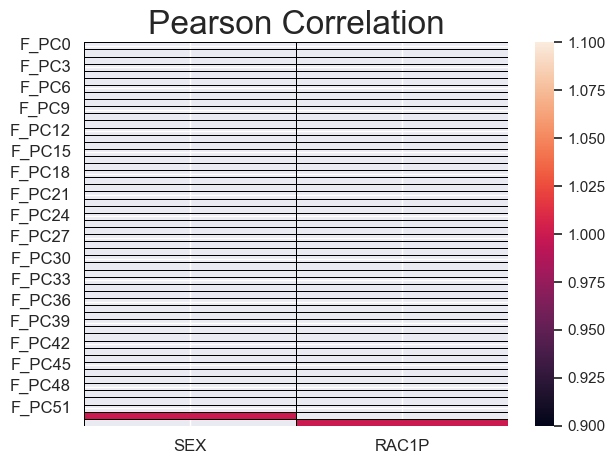

In [444]:
heatmap_filtered_relevant(task_3_merged.corr(method='pearson')[['SEX', 'RAC1P']], p_values[['SEX', 'RAC1P']], corrected_alpha, 'Pearson Correlation')

## Point 4

In [445]:
X_prim_pca, U, _Z = fair_pca(X_test, group_test)
X_prim_pca.shape
# project back

X_test_fair_pca_proj_back = np.dot(X_prim_pca, U.T)
rec_errors = X_test - X_test_fair_pca_proj_back
rec_errors

array([[ 6.02025644e-02,  3.37881231e-01, -4.53118209e-02, ...,
         2.18372520e-02,  9.02231559e-05,  5.14255006e-02],
       [ 3.92632894e-02,  1.79655155e-01, -4.39969341e-02, ...,
         1.25888208e-02, -4.29857053e-04,  3.00953735e-02],
       [-1.96746757e-02, -1.80513608e-02,  4.75872826e-02, ...,
        -3.38528918e-03,  1.07947123e-03, -8.99196331e-03],
       ...,
       [ 5.87285110e-02,  3.27029203e-01, -4.51175724e-02, ...,
         2.11978311e-02,  5.70514228e-05,  4.99481736e-02],
       [ 6.16179215e-02,  4.23042790e-01, -1.89752838e-02, ...,
         2.54865635e-02,  1.01938330e-03,  5.91669182e-02],
       [ 5.58944341e-02,  1.96045381e-01, -8.38213561e-02, ...,
         1.54963728e-02, -1.32876027e-03,  3.77920476e-02]])

In [446]:
rec_errors_fair_pd = pd.DataFrame(rec_errors, columns=features_no_protected.columns)
rec_errors_fair_pd

,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Institutionalized group quarters population,RELP_Noninstitutionalized group quarters population,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner
0,0.060203,0.337881,-0.045312,0.467500,-0.306304,0.013033,-0.446420,0.214467,0.218591,-0.161879,...,0.000032,-0.042620,0.015362,-0.036288,0.000892,0.197700,0.004948,0.021837,0.000090,0.051426
1,0.039263,0.179655,-0.043997,0.269525,-0.153066,-0.024019,-0.277496,0.132379,0.148684,-0.097137,...,-0.016983,-0.043713,0.006996,-0.026373,0.001170,0.131842,-0.002258,0.012589,-0.000430,0.030095
2,-0.019675,-0.018051,0.047587,-0.072515,-0.005872,0.069532,0.114914,-0.053085,-0.085329,0.033755,...,0.038574,0.050047,0.001838,0.018000,-0.001627,-0.071201,0.010830,-0.003385,0.001079,-0.008992
3,0.006183,0.340265,0.103779,0.313540,-0.382023,0.245441,-0.148331,0.078276,-0.023503,-0.079970,...,0.127639,0.115103,0.024266,0.016588,-0.004327,-0.001500,0.041682,0.014652,0.003678,0.031131
4,0.062537,0.429263,-0.019291,0.553652,-0.407990,0.076072,-0.489986,0.237194,0.215296,-0.184385,...,0.032730,-0.013665,0.021770,-0.032491,-0.000206,0.199781,0.015688,0.025863,0.001033,0.060042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.018387,0.236454,0.033448,0.258582,-0.246434,0.110434,-0.181040,0.090034,0.046723,-0.077067,...,0.055672,0.039088,0.014586,-0.002224,-0.001655,0.050874,0.019467,0.012081,0.001627,0.026980
19996,0.003714,0.238000,0.074265,0.217543,-0.268033,0.174281,-0.100372,0.053206,-0.019172,-0.055004,...,0.090709,0.082282,0.017072,0.012198,-0.003085,-0.003299,0.029567,0.010166,0.002613,0.021543
19997,0.058729,0.327029,-0.045118,0.453812,-0.295845,0.010654,-0.434624,0.208741,0.213627,-0.157381,...,-0.001046,-0.042585,0.014794,-0.035571,0.000907,0.193043,0.004479,0.021198,0.000057,0.049948
19998,0.061618,0.423043,-0.018975,0.545591,-0.402095,0.075026,-0.482813,0.233724,0.212117,-0.181693,...,0.032287,-0.013428,0.021456,-0.032008,-0.000204,0.196837,0.015469,0.025487,0.001019,0.059167


In [447]:
task_4_merged = pd.concat([rec_errors_fair_pd.reset_index(), group_test.reset_index()], axis=1)
task_4_merged = task_4_merged.drop(["index"], axis = 1)
task_4_merged

,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX,RAC1P
0,0.060203,0.337881,-0.045312,0.467500,-0.306304,0.013033,-0.446420,0.214467,0.218591,-0.161879,...,0.015362,-0.036288,0.000892,0.197700,0.004948,0.021837,0.000090,0.051426,2,1
1,0.039263,0.179655,-0.043997,0.269525,-0.153066,-0.024019,-0.277496,0.132379,0.148684,-0.097137,...,0.006996,-0.026373,0.001170,0.131842,-0.002258,0.012589,-0.000430,0.030095,1,1
2,-0.019675,-0.018051,0.047587,-0.072515,-0.005872,0.069532,0.114914,-0.053085,-0.085329,0.033755,...,0.001838,0.018000,-0.001627,-0.071201,0.010830,-0.003385,0.001079,-0.008992,1,1
3,0.006183,0.340265,0.103779,0.313540,-0.382023,0.245441,-0.148331,0.078276,-0.023503,-0.079970,...,0.024266,0.016588,-0.004327,-0.001500,0.041682,0.014652,0.003678,0.031131,1,1
4,0.062537,0.429263,-0.019291,0.553652,-0.407990,0.076072,-0.489986,0.237194,0.215296,-0.184385,...,0.021770,-0.032491,-0.000206,0.199781,0.015688,0.025863,0.001033,0.060042,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.018387,0.236454,0.033448,0.258582,-0.246434,0.110434,-0.181040,0.090034,0.046723,-0.077067,...,0.014586,-0.002224,-0.001655,0.050874,0.019467,0.012081,0.001627,0.026980,2,1
19996,0.003714,0.238000,0.074265,0.217543,-0.268033,0.174281,-0.100372,0.053206,-0.019172,-0.055004,...,0.017072,0.012198,-0.003085,-0.003299,0.029567,0.010166,0.002613,0.021543,1,1
19997,0.058729,0.327029,-0.045118,0.453812,-0.295845,0.010654,-0.434624,0.208741,0.213627,-0.157381,...,0.014794,-0.035571,0.000907,0.193043,0.004479,0.021198,0.000057,0.049948,1,1
19998,0.061618,0.423043,-0.018975,0.545591,-0.402095,0.075026,-0.482813,0.233724,0.212117,-0.181693,...,0.021456,-0.032008,-0.000204,0.196837,0.015469,0.025487,0.001019,0.059167,1,1


In [448]:
group1_rec_error = task_4_merged.loc[task_4_merged["SEX"] == 1].mean().mean()
group2_rec_error = task_4_merged.loc[task_4_merged["SEX"] == 2].mean().mean()
group3_rec_error = task_4_merged.loc[task_4_merged["RAC1P"] == 1].mean().mean()
group4_rec_error = task_4_merged.loc[task_4_merged["RAC1P"] == 2].mean().mean()

In [449]:
print(f"Group 1 reconstruction error mean: {group1_rec_error}")
print(f"Group 2 reconstruction error mean: {group2_rec_error}")
print(f"Group 3 reconstruction error mean: {group3_rec_error}")
print(f"Group 4 reconstruction error mean: {group4_rec_error}")

Group 1 reconstruction error mean: 0.046904772755812986
Group 2 reconstruction error mean: 0.06299851637525218
Group 3 reconstruction error mean: 0.05322209063928001
Group 4 reconstruction error mean: 0.07045822311334259


## Task 2.5 (Jorge)

In [450]:
X_test_fair_pca, _, _ = fair_pca(X_test, group_test)
X_test_fair_pca # 52 fair PCA components, they suggested using only first 30
# X_test_fair_pca is without protected groups

(20000, 52)

In [451]:
group_test

,SEX,RAC1P
72476,2,1
108056,1,1
128094,1,1
46044,1,1
42380,1,1
...,...,...
78970,2,1
53318,1,1
89865,1,1
103333,1,1
